In [1]:
data = {
    'ethanol'          : {'MW':  46.07, 'SG': 0.791, 'A': 8.04494, 'B': 1554.3,  'C': 222.65},
    'methanol'         : {'MW':  32.04, 'SG': 0.791, 'A': 7.89750, 'B': 1474.08, 'C': 229.13},
    'isopropyl alcohol': {'MW':  60.10, 'SG': 0.785, 'A': 8.11778, 'B': 1580.92, 'C': 219.61},
    'acetone'          : {'MW':  58.08, 'SG': 0.787, 'A': 7.02447, 'B': 1161.0,  'C': 224.0},
    'xylene'           : {'MW': 106.16, 'SG': 0.870, 'A': 6.99052, 'B': 1453.43, 'C': 215.31},
    'toluene'          : {'MW':  92.14, 'SG': 0.865, 'A': 6.95464, 'B': 1344.8,  'C': 219.48},
}

Vapor Pressure at 0C = 22.1 mmHg


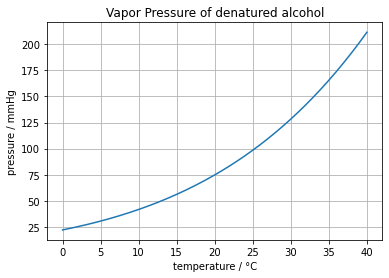

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def Pvap(T, s):
    return 10**(data[s]['A'] - data[s]['B']/(T + data[s]['C']))

def Pvap_denatured(T):
    return 0.4*Pvap(T, 'ethanol') + 0.6*Pvap(T, 'methanol')

T = np.linspace(0, 40, 200)

plt.plot(T, Pvap_denatured(T))
plt.title('Vapor Pressure of denatured alcohol')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
plt.grid()
print("Vapor Pressure at 0C =", round(Pvap_denatured(0),1), "mmHg")

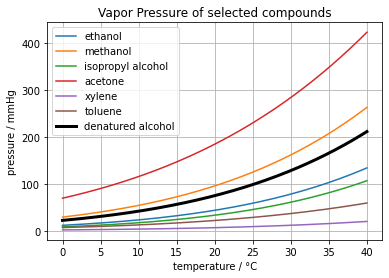

In [3]:
for s in data.keys():
    plt.plot(T, Pvap(T,s))
plt.plot(T, Pvap_denatured(T), 'k', lw=3)
plt.legend(list(data.keys()) + ['denatured alcohol'])
plt.title('Vapor Pressure of selected compounds')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
plt.grid()

Vapor Pressure at -10°C = 17.481785425221528 mmHg


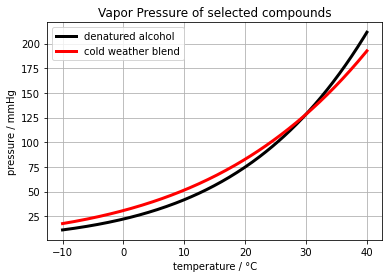

In [4]:
import pyomo.environ as pyomo

m = pyomo.ConcreteModel()

S = data.keys()
m.x = pyomo.Var(S, domain=pyomo.NonNegativeReals)

def Pmix(T):
    return sum(m.x[s]*Pvap(T,s) for s in S)

m.obj = pyomo.Objective(expr = Pmix(-10), sense=pyomo.maximize)

m.cons = pyomo.ConstraintList()

m.cons.add(sum(m.x[s] for s in S)==1)
m.cons.add(Pmix(30) <= Pvap_denatured(30))
m.cons.add(Pmix(40) <= Pvap_denatured(40))

solver = pyomo.SolverFactory('glpk')
solver.solve(m)

print("Vapor Pressure at -10°C =", m.obj(), "mmHg")

T = np.linspace(-10,40,200)
plt.plot(T, Pvap_denatured(T), 'k', lw=3)
plt.plot(T, [Pmix(T)() for T in T], 'r', lw=3)
plt.legend(['denatured alcohol'] + ['cold weather blend'])
plt.title('Vapor Pressure of selected compounds')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
plt.grid()

In [5]:
import pandas as pd

s = data.keys()
results = pd.DataFrame.from_dict(data).T
for s in S:
    results.loc[s,'mole fraction'] = m.x[s]()
    
MW = sum(m.x[s]()*data[s]['MW'] for s in S)
for s in S:
    results.loc[s,'mass fraction'] = m.x[s]()*data[s]['MW']/MW
    
vol = sum(m.x[s]()*data[s]['MW']/data[s]['SG'] for s in S)
for s in S:
    results.loc[s,'vol fraction'] = m.x[s]()*data[s]['MW']/data[s]['SG']/vol

results

,MW,SG,A,B,C,mole fraction,mass fraction,vol fraction
ethanol,46.07,0.791,8.04494,1554.30,222.65,0.000000,0.0000,0.000000
methanol,32.04,0.791,7.89750,1474.08,229.13,0.000000,0.0000,0.000000
isopropyl alcohol,60.10,0.785,8.11778,1580.92,219.61,0.000000,0.0000,0.000000
acetone,58.08,0.787,7.02447,1161.00,224.00,0.428164,0.2906,0.311695
xylene,106.16,0.870,6.99052,1453.43,215.31,0.571836,0.7094,0.688305
toluene,92.14,0.865,6.95464,1344.80,219.48,0.000000,0.0000,0.000000
